In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

class RareDiseaseFewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None, n_way=2, k_shot=5, k_query=5):
        self.root_dir = root_dir
        self.transform = transform
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query
        self.image_files = {"Pink Disease": [], "Nematode": []}

        # Load images by class
        for class_name in self.image_files.keys():
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".jpg"):
                        # Get the label from the corresponding .txt file
                        label_file = file.replace(".jpg", ".txt")
                        label_path = os.path.join(class_path, label_file)
                        
                        # Read the label file
                        with open(label_path, "r") as f:
                            label = int(f.readline().split()[0])  # Get the class id
                        
                        self.image_files[class_name].append((os.path.join(class_path, file), label))

        # Ensure enough images for few-shot learning
        for class_name, images in self.image_files.items():
            if len(images) < k_shot + k_query:
                raise ValueError(f"Not enough samples in '{class_name}' for {k_shot}-shot learning!")

    def sample_task(self):
        """Samples an N-way K-shot learning task."""
        sampled_classes = random.sample(list(self.image_files.keys()), self.n_way)
        support_set, query_set, labels = [], [], []

        for label, class_name in enumerate(sampled_classes):
            class_images = random.sample(self.image_files[class_name], self.k_shot + self.k_query)
            support_set.extend([(img, label) for img, label in class_images[:self.k_shot]])
            query_set.extend([(img, label) for img, label in class_images[self.k_shot:]])

        return support_set, query_set

    def __getitem__(self, _):
        """Returns a single few-shot task."""
        support_set, query_set = self.sample_task()

        def load_images(image_list):
            images, labels = [], []
            for img_path, label in image_list:
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                images.append(image)
                labels.append(label)
            return torch.stack(images), torch.tensor(labels)

        support_images, support_labels = load_images(support_set)
        query_images, query_labels = load_images(query_set)

        return support_images, support_labels, query_images, query_labels

    def __len__(self):
        return 1000  # Generate 1000 tasks

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset for few-shot learning
fewshot_dataset = RareDiseaseFewShotDataset("D:/Capstone Project/rare_disease", transform)
fewshot_dataloader = DataLoader(fewshot_dataset, batch_size=1, shuffle=True)

# Test dataset loading
for support_images, support_labels, query_images, query_labels in fewshot_dataloader:
    print(f"Support Set: {support_images.shape}, Labels: {support_labels}")
    print(f"Query Set: {query_images.shape}, Labels: {query_labels}")
    break

Support Set: torch.Size([1, 10, 3, 224, 224]), Labels: tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])
Query Set: torch.Size([1, 10, 3, 224, 224]), Labels: tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ProtoNetWithResNet50(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ProtoNetWithResNet50, self).__init__()
        
        # Load pre-trained ResNet-50 model
        resnet50 = models.resnet50(pretrained=True)
        
        # Remove the fully connected layer (the classifier) from ResNet-50
        self.feature_extractor = nn.Sequential(*list(resnet50.children())[:-1])
        
        # Add a new fully connected layer to map the feature to the embedding space
        self.fc = nn.Linear(resnet50.fc.in_features, embedding_dim)
    
    def forward(self, x):
        # Extract features from the image using the ResNet-50 backbone
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, feature_size)
        
        # Pass the features through the fully connected layer to get embeddings
        return self.fc(x)
    

def compute_prototypes(support_images, support_labels, model):
    """Computes class prototypes as mean embeddings."""
    unique_classes = support_labels.unique()
    prototypes = []
    for cls in unique_classes:
        class_indices = (support_labels == cls).nonzero(as_tuple=True)[0]
        class_embeddings = model(support_images[class_indices])  # Get embeddings
        prototypes.append(class_embeddings.mean(dim=0))  # Compute mean
    return torch.stack(prototypes)

def classify_query(prototypes, query_images, model):
    """Assigns query images to nearest prototype."""
    query_embeddings = model(query_images)  # Get embeddings for query images
    distances = torch.cdist(query_embeddings, prototypes)  # Compute Euclidean distance to prototypes
    return distances  # Return raw distance (logits for the cross-entropy loss)



In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Initialize the ResNet-50 based ProtoNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProtoNetWithResNet50(embedding_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of episodes (tasks)
num_episodes = 1000

# Training loop
for episode in range(num_episodes):
    support_images, support_labels, query_images, query_labels = next(iter(fewshot_dataloader))

    # Move data to device
    support_images, support_labels = support_images.squeeze(0).to(device), support_labels.squeeze(0).to(device)
    query_images, query_labels = query_images.squeeze(0).to(device), query_labels.squeeze(0).to(device)

    # Compute prototypes (embedding space representation for support images)
    prototypes = compute_prototypes(support_images, support_labels, model)

    # Classify query images by comparing to prototypes
    predictions = classify_query(prototypes, query_images, model)

    # Compute the loss (cross-entropy between predicted and true labels)
    loss = F.cross_entropy(predictions, query_labels)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate accuracy for this episode
    predicted_classes = torch.argmax(predictions, dim=1)
    acc = (predicted_classes == query_labels).float().mean().item()

    # Print statistics every 10 episodes
    if episode % 10 == 0:
        print(f"Episode {episode}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}")
        



c:\Users\hoang\anaconda3\envs\coffe_leaf_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hoang\anaconda3\envs\coffe_leaf_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Episode 0: Loss = 0.6971, Accuracy = 0.2000
Episode 10: Loss = 0.0459, Accuracy = 1.0000
Episode 20: Loss = 0.6835, Accuracy = 0.9000
Episode 30: Loss = 0.6544, Accuracy = 0.6000
Episode 40: Loss = 1.0773, Accuracy = 0.3000
Episode 50: Loss = 0.9709, Accuracy = 0.0000
Episode 60: Loss = 0.2661, Accuracy = 1.0000
Episode 70: Loss = 0.1224, Accuracy = 1.0000
Episode 80: Loss = 0.0189, Accuracy = 1.0000
Episode 90: Loss = 0.5789, Accuracy = 0.8000
Episode 100: Loss = 0.2237, Accuracy = 0.9000
Episode 110: Loss = 0.0055, Accuracy = 1.0000
Episode 120: Loss = 0.0211, Accuracy = 1.0000
Episode 130: Loss = 0.0054, Accuracy = 1.0000
Episode 140: Loss = 0.0107, Accuracy = 1.0000
Episode 150: Loss = 0.0057, Accuracy = 1.0000
Episode 160: Loss = 0.0205, Accuracy = 1.0000
Episode 170: Loss = 0.0003, Accuracy = 1.0000
Episode 180: Loss = 0.0090, Accuracy = 1.0000
Episode 190: Loss = 0.0722, Accuracy = 1.0000
Episode 200: Loss = 0.1883, Accuracy = 1.0000
Episode 210: Loss = 0.0644, Accuracy = 1.0000

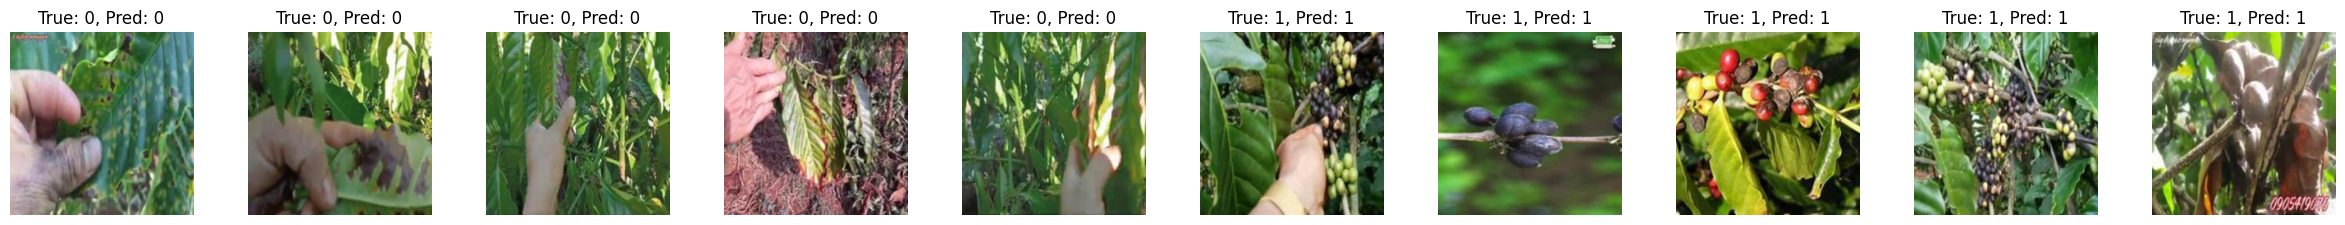

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(support_images, support_labels, query_images, query_labels, predictions):
    # Convert the images to numpy arrays for visualization
    query_images = query_images.cpu().numpy()
    
    # Get the predicted classes from the model's output (highest probability class)
    predicted_classes = torch.argmax(predictions, dim=1)

    # Set up the plot with a larger figure size
    num_images = len(query_images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 5))  # Increase figure size

    # If only one image is displayed, axes will be a single axis, not a list.
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        # Get the actual label and predicted label
        actual_label = query_labels[i].item()
        predicted_label = predicted_classes[i].item()

        # Convert the image back to the correct format for plotting
        image = query_images[i].transpose(1, 2, 0)  # Change to HxWxC

        # Clip the pixel values to be in [0, 1]
        image = np.clip(image, 0, 1)

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')

        # Set the title with actual and predicted labels
        axes[i].set_title(f"True: {actual_label}, Pred: {predicted_label}")

    # Adjust spacing between subplots to prevent overlap
    plt.subplots_adjust(wspace=0.3)  # Add more space between images
    plt.show()

# After training loop, call the visualization function
visualize_predictions(support_images, support_labels, query_images, query_labels, predictions)